In [81]:
import torch
import torch.nn.functional as F
import torchsde

from torchvision import datasets, transforms

import math
import numpy as np
import pandas as pd
from tqdm import tqdm

from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import functorch

import matplotlib.pyplot as plt

import cfollmer.functional as functional
from cfollmer.objectives import relative_entropy_control_cost
from cfollmer.drifts import SimpleForwardNet, SimpleForwardNetBN, ResNetScoreNetwork
from cfollmer.sampler_utils import FollmerSDE

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
class DNN(torch.nn.Module):
    
    def __init__(self, input_dim=1, output_dim=1):
        super(DNN, self).__init__()
        
        self.output_dim = output_dim
        self.input_dim = input_dim
        
        self.nn = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, output_dim)
        )
        
    def forward(self, x):
        return self.nn(x)

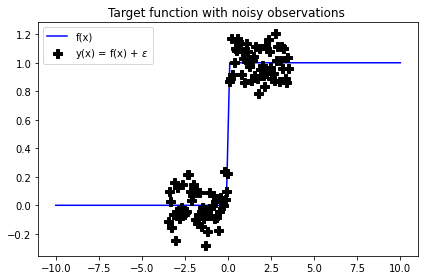

In [4]:
np.random.seed(123)
sigma_n = 0.1

N_train = 100
N_test = 100

# Test inputs
X_train = np.linspace(-3.5, 3.5, N_train).reshape(-1,1)
X_test = np.linspace(-10, 10, N_train).reshape(-1, 1)

f_train = np.heaviside(X_train, 0)
f_test = np.heaviside(X_test, 0)

y_train = f_train + sigma_n * np.random.randn(*f_train.shape)
y_test = f_test # No need for noise I guess

# Noisy observations
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
ax.plot(X_test, y_test, 'b', label = 'f(x)')
ax.plot(X_train, y_train, 'kP', ms = 9, label = 'y(x) = f(x) + $\epsilon$')
ax.legend(loc = 'upper left')
ax.set_title('Target function with noisy observations ')

plt.show()

In [5]:
X_train = torch.tensor(X_train, device=device, dtype=torch.float)
X_test = torch.tensor(X_test, device=device, dtype=torch.float)

y_train = torch.tensor(y_train, device=device, dtype=torch.float)
y_test = torch.tensor(y_test, device=device, dtype=torch.float)

In [6]:
model = DNN().to(device)
func_model, params = functorch.make_functional(model)
size_list = functional.params_to_size_tuples(params)
dim = functional.get_number_of_params(size_list)

sigma2 = 0.1

def log_prior(params):
    return -torch.sum(params**2) / (2 * sigma2)

def log_likelihood(x, y, params):
    preds = func_model(functional.get_params_from_array(params, size_list), x)
    diff = preds - y
    
    return - torch.sum(diff**2) / (2 * sigma_n**2)

def log_posterior(x, y, params):
    return log_prior(params) + (N_train / x.shape[0]) * log_likelihood(x, y, params)

def log_posterior_batch(x, y, params_batch):
    func = lambda params: log_posterior(x, y, params)
    func = functorch.vmap(func)
    return func(params_batch)

In [7]:
gamma = 0.05**2

n_steps = 300
data_batch_size = 50
param_batch_size = 32

In [8]:
def train(gamma, n_steps, data_batch_size, param_batch_size, dt=0.05):
    sde = FollmerSDE(gamma, SimpleForwardNetBN(input_dim=dim, width=300)).to(device)
    optimizer = torch.optim.Adam(sde.parameters(), lr=1e-4)
    
    losses = []

    for _ in tqdm(range(n_steps)):
        perm = torch.randperm(N_train)
        x = X_train[perm[:data_batch_size], :]
        y = y_train[perm[:data_batch_size], :]

        optimizer.zero_grad()
        
        partial_log_p = lambda params_batch: log_posterior_batch(x, y, params_batch)
        
        loss = relative_entropy_control_cost(sde, partial_log_p, param_batch_size=param_batch_size, dt=dt, device=device)
        loss.backward()
        
        losses.append(loss.detach().cpu().numpy())
        optimizer.step()
    
    losses = np.array(losses)
    
    return sde, losses

In [44]:
def predict(param_samples, x):
    with torch.no_grad():
        predict_func = lambda params : func_model(functional.get_params_from_array(params, size_list), x)
        predict_func = functorch.vmap(predict_func)

        preds = predict_func(param_samples)

        std, mean = torch.std_mean(preds, dim=0)
    return std, mean

In [47]:
def plot_fit(mean, std, title="", fn=None):
    x = X_test.cpu().squeeze()
    std = std.cpu().squeeze()
    mean = mean.cpu().squeeze()
    
    plt.plot(x, mean)
    plt.fill_between(x, mean - 2 * std, mean + 2 * std, alpha=0.2)
    plt.plot(X_train.cpu(), y_train.cpu(), 'kP', ms = 9)
    plt.title(title)
    plt.legend(["mean prediction", "data", r"$\pm 2\sigma^2$"], loc="upper left")
    if fn is not None:
        plt.savefig(fn, bbox_inches="tight", dpi=600)
        plt.close()

In [11]:
sde, losses = train(gamma, n_steps, data_batch_size, param_batch_size)

  0%|                                                                        | 0/300 [00:00<?, ?it/s]/home/ao464@ad.eng.cam.ac.uk/repos/ControlledFollmerDrift/env/lib/python3.8/site-packages/torch/nn/functional.py:2384: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::batch_norm. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at  /tmp/pip-req-build-b9xxrrfi/functorch/csrc/BatchedFallback.cpp:106.)
  return torch.batch_norm(
100%|██████████████████████████████████████████████████████████████| 300/300 [00:09<00:00, 30.43it/s]


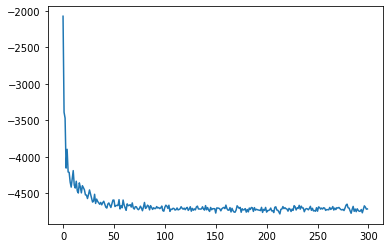

In [12]:
plt.plot(losses)

In [13]:
param_samples = sde.sample(100, dt=0.01, device=device)
std, mean = predict(param_samples, X_test)

plot_fit(mean, std, title="SBP fit", fn="plots/step_func/sbp_fit.png")

In [14]:
n_runs = 5

sbp_mse = []

for i in range(n_runs):
    sde, losses = train(gamma, n_steps, data_batch_size, param_batch_size)
    
    with torch.no_grad():
        param_samples = sde.sample(100, dt=0.01, device=device)
    
    std, mean = predict(param_samples, X_test)
    
    plot_fit(mean, std, title="SBP fit #{}".format(i+1), fn="plots/step_func/sbp_fit_#{:d}.png".format(i+1))
    
    sbp_mse.append(torch.mean((y_test - mean)**2).cpu().numpy())
    
sbp_mse = np.array(sbp_mse)

  0%|                                                                        | 0/300 [00:00<?, ?it/s]/home/ao464@ad.eng.cam.ac.uk/repos/ControlledFollmerDrift/env/lib/python3.8/site-packages/torch/nn/functional.py:2384: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::batch_norm. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at  /tmp/pip-req-build-b9xxrrfi/functorch/csrc/BatchedFallback.cpp:106.)
  return torch.batch_norm(
  0%|                                                                        | 0/300 [00:00<?, ?it/s]/home/ao464@ad.eng.cam.ac.uk/repos/ControlledFollmerDrift/env/lib/python3.8/site-packages/torch/nn/functional.py:2384: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::batch_norm. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at  /tmp/pip-req-build

In [16]:
@torch.enable_grad()
def gradient(x, y, params):
    params_ = params.clone().requires_grad_(True)
    loss = log_posterior(x, y, params_)
    grad, = torch.autograd.grad(loss, params_)
    return loss.detach().cpu().numpy(), grad

In [57]:
def step_size(n):
    return 1e-4/ (1 + n)**0.1

In [58]:
def sgld(n_steps, last_n, data_batch_size):
    losses = []
    param_samples = []
    
    params = torch.zeros(dim).float().to(device)
    
    for step in tqdm(range(n_steps)):
        perm = torch.randperm(N_train)
        x = X_train[perm[:data_batch_size], :]
        y = y_train[perm[:data_batch_size], :]

        eps = step_size(step)
        loss, grad = gradient(x, y, params)
        params = params + 0.5 * eps * grad + np.sqrt(eps) * torch.randn_like(params)
        
        if n_steps <= step + last_n:
            param_samples.append(params)
        losses.append(loss)
        
    param_samples = torch.stack(param_samples)
    
    return param_samples, losses

In [69]:
param_samples, losses = sgld(10000, 2000, data_batch_size)

100%|████████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1312.63it/s]


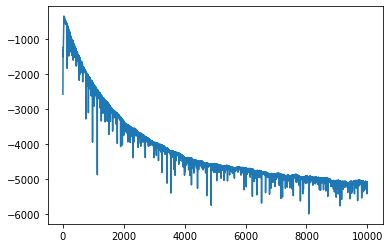

In [70]:
plt.plot(losses)

In [77]:
std, mean = predict(param_samples[:100], X_test)

In [79]:
plot_fit(mean, std, title="SGLD fit", fn="plots/step_func/sgld_fit.png")

In [80]:
n_runs = 5
n_steps = 10000

sgld_mse = []

for i in range(n_runs):
    param_samples, losses = sgld(n_steps, 1000, data_batch_size)
    
    std, mean = predict(param_samples[:100], X_test)
    plot_fit(mean, std, title="SGLD fit #{} (100 samples)".format(i+1), fn="plots/step_func/sgld_fit_#{:d}_100.png".format(i+1))
    
    sgld_mse.append(torch.mean((y_test - mean)**2).cpu().numpy())
    
    std, mean = predict(param_samples[:500], X_test)
    plot_fit(mean, std, title="SGLD fit #{} (500 samples)".format(i+1), fn="plots/step_func/sgld_fit_#{:d}_500.png".format(i+1))
    
    std, mean = predict(param_samples, X_test)
    plot_fit(mean, std, title="SGLD fit #{} (1000 samples)".format(i+1), fn="plots/step_func/sgld_fit_#{:d}_1000.png".format(i+1))
    
sgld_mse = np.array(sgld_mse)

100%|████████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1283.59it/s]


In [84]:
df = pd.DataFrame({"SBP": sbp_mse, "SGLD": sgld_mse})

In [85]:
df

,SBP,SGLD
0,0.003754,0.260998
1,0.004114,0.015904
2,0.006420,0.012447
3,0.005728,0.151364
4,0.003240,0.191346


In [87]:
df.describe()

,SBP,SGLD
count,5.000000,5.000000
mean,0.004651,0.126412
std,0.001357,0.109718
min,0.003240,0.012447
25%,0.003754,0.015904
50%,0.004114,0.151364
75%,0.005728,0.191346
max,0.006420,0.260998
